# 1. Context and data upload

Data comes from [sg.openfoodfacts.org](https://sg.openfoodfacts.org/).

I tailored it as I only selected data from Singapore (main website is [openfoodfacts.org](https://world.openfoodfacts.org/)), but there is too much data to download and then use.

First I downloaded the CSV file (2.2Mo).
- File is now on my computer, ready to be uploaded,
- Cloud storage may be considered, but not at this point for me (paid option).

__Next step is to upload the CSV file in here.__

In [1]:
# Upload the file on Colab (less than 1 minute)
from google.colab import files

uploaded = files.upload()

Saving openfoodfacts_export.csv to openfoodfacts_export.csv


In [ ]:
# IDEA: append the data from Malaysia for a bigger dataset?

# IDEA 2: also append data from Thailand/Indonesia?
# -> check if product_name_(lang) is not impacted

In [2]:
# First start by importing the packages used

# Work on data
import numpy as np
import pandas as pd
# Dataframe display
from tabulate import tabulate
# Plot missing values
import missingno as msno
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

According to online documentation:
- file is delimited using tabulation
- file encoding is UTF-8

In [3]:
# Read the file and create the dataset:
#init_data = pd.read_csv('openfoodfacts_export.csv', sep='\t')

# Check if difference with encoding?
init_data = pd.read_csv('openfoodfacts_export.csv', sep='\t', encoding='utf-8')

<ipython-input-3-f01b1671cb83>:5: DtypeWarning: Columns (1,3,4,5,6,7,9,10,11,13,14,15,16,18,19,20,22,23,24,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,67,80,81,86,87,88,89,91,92,93,94,95,96,97,98,100,101,102,103,104,105,106,107,108,109,110,111,112,114,115,150,166,172,174,176,178,180,182,184,186,188,190,192,200,204,206,208,210,216,218,222,224,226,228,236,240,252,256,260,278,280,282,284,290,292,294,296,314,318,319,320,321,322,323,325,326,337,343,344,345,347,348,351,352,353,354,355,356) have mixed types. Specify dtype option on import or set low_memory=False.
  init_data = pd.read_csv('openfoodfacts_export.csv', sep='\t', encoding='utf-8')


# 2. Overview of the data and pre-selection based on language

In [4]:
# Let's have a look at the shape first:
print("This dataset contains {} rows and {} columns".format(
    init_data.shape[0], init_data.shape[1]))

This dataset contains 3410 rows and 358 columns


In [17]:
# Display all the columns (358) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

init_data.head(5)

,code,producer_version_id,lc,product_name_ar,product_name_bg,product_name_cs,product_name_da,product_name_de,product_name_en,product_name_es,...,sources_fields:org-database-usda:publication_date,sources_fields:org-gs1:gln,sources_fields:org-gs1:gpcCategoryCode,sources_fields:org-gs1:gpcCategoryName,sources_fields:org-gs1:isAllergenRelevantDataProvided,sources_fields:org-gs1:lastChangeDateTime,sources_fields:org-gs1:partyName,sources_fields:org-gs1:productionVariantDescription,sources_fields:org-gs1:publicationDateTime,data_sources
0,8888196441119,NaN,fr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Open Food Facts"
1,4037300108293,NaN,de,NaN,NaN,NaN,NaN,Linseneintopf mit Würstchen,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Speisekammer..."
2,8076802085981,1,it,NaN,Fusilli,NaN,NaN,Fusilli,Fusilli Pasta,NaN,...,NaN,3.012289e+12,10000242.0,Pâtes/Nouilles - Non Prêt à Consomme...,True,2022-12-29T11:06:43+01:00,BARILLA FRANCE SA,1,2022-12-29T11:06:43+01:00,"Producers, Producer - Barilla, Datab..."
3,73390000110,NaN,en,NaN,NaN,NaN,NaN,NaN,Mint Mentos,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Horizon, App..."
4,734349,NaN,en,NaN,NaN,NaN,NaN,NaN,Honey roasted cashews,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Horizon, App..."


In [18]:
# I will now go through the different columns and, based on the language,
# remove the ones that are too empty.
# Start by initializing an empty list:
removed_columns = []

## 2.1. Selection of the 'product_name_[...]'

In [46]:
# Each product is named in different languages, I'll check their completion.
# Use of RegEx: https://www.w3schools.com/python/python_regex.asp
# Display all the columns (33) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

prod_name_lang_df = init_data.filter(regex=('^product_name_'))
prod_name_lang_df.head(5)

,product_name_ar,product_name_bg,product_name_cs,product_name_da,product_name_de,product_name_en,product_name_es,product_name_et,product_name_fi,product_name_fr,...,product_name_ro,product_name_ru,product_name_sk,product_name_sr,product_name_sv,product_name_ta,product_name_th,product_name_tr,product_name_uk,product_name_zh
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Straight Red Tea,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Linseneintopf mit Würstchen,NaN,NaN,NaN,NaN,Erasco Linsen Eintopf mit Würdtchebn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Fusilli,NaN,NaN,Fusilli,Fusilli Pasta,NaN,NaN,NaN,Fusilli,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,Mint Mentos,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,Honey roasted cashews,NaN,NaN,NaN,Honey roasted cashews,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# I also save these columns in a list:
prod_name_lang_list = init_data.filter(
    regex=('^product_name_')).columns.to_list()

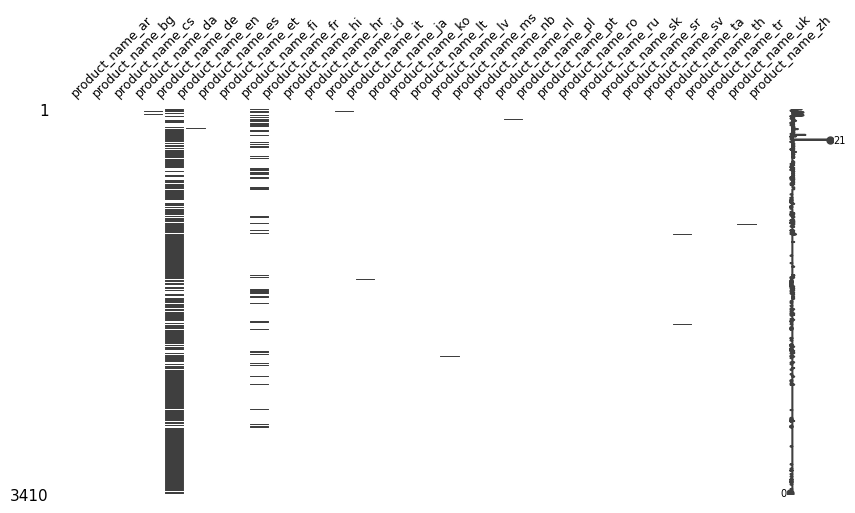

In [21]:
_ = msno.matrix(df=prod_name_lang_df, figsize=(10,5), fontsize=9)

In [22]:
# Since the product names are mostly available in English (also in French,
# but in a lesser extent), I only keep the '_en' variable:
prod_name_lang_list.remove('product_name_en')

In [23]:
# I add the other columns in the removal list:
removed_columns.extend(prod_name_lang_list)

## 2.2. Selection of the 'abbreviated_product_name_[...]'

In [24]:
# There is only one column at that time, but that may change:
abv_prod_name_lang_df = init_data.filter(regex=('^abbreviated_product_name_'))
abv_prod_name_lang_df.head(5)

,abbreviated_product_name_fr
0,NaN
1,NaN
2,Barilla fusilli 500g
3,NaN
4,NaN


In [25]:
# I also save this column (for now?) in a list:
abv_prod_name_lang_list = init_data.filter(
    regex=('^abbreviated_product_name_')).columns.to_list()

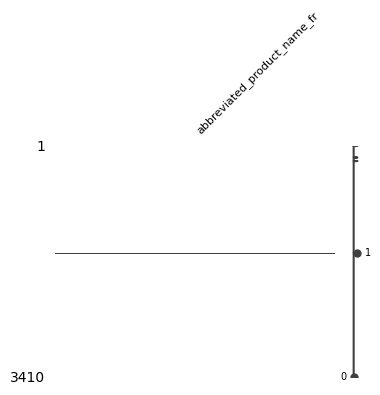

In [26]:
_ = msno.matrix(df=abv_prod_name_lang_df, figsize=(4,3), fontsize=8)

In [27]:
# This does not seem to be useful, so I add the column in the removal list.
removed_columns.extend(abv_prod_name_lang_list)

## 2.3. Selection of the 'generic_name_[...]'

In [47]:
# Each product is named in different languages, I'll check their completion:
# Display all the columns (24) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

gen_name_lang_df = init_data.filter(regex=('^generic_name_'))
gen_name_lang_df.head(5)

,generic_name_ar,generic_name_bg,generic_name_cs,generic_name_da,generic_name_de,generic_name_en,generic_name_es,generic_name_et,generic_name_fi,generic_name_fr,...,generic_name_lv,generic_name_nb,generic_name_nl,generic_name_pl,generic_name_pt,generic_name_ro,generic_name_sk,generic_name_sr,generic_name_sv,generic_name_th
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pâtes alimentaires de qualité supéri...,...,NaN,NaN,NaN,NaN,Massa Fusilli,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# I also save these columns in a list:
gen_name_lang_list = init_data.filter(
    regex=('^generic_name_')).columns.to_list()

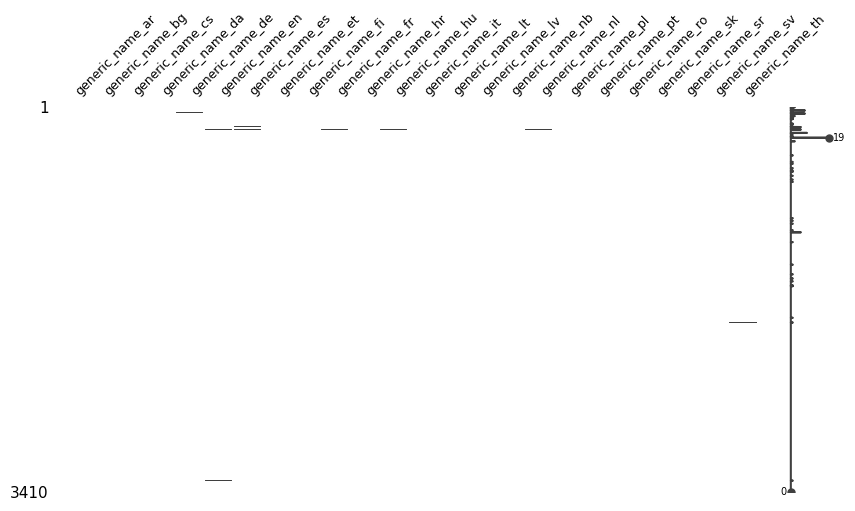

In [30]:
_ = msno.matrix(df=gen_name_lang_df, figsize=(10,5), fontsize=9)

In [31]:
# This does not seem to be useful, so I add the columns in the removal list:
removed_columns.extend(gen_name_lang_list)

## 2.4. Selection of the 'origin_[...]'

In [32]:
# There are only two columns at that time, but that may change:
origin_lang_df = init_data.filter(regex=('^origin_'))
origin_lang_df.head(5)

,origin_en,origin_fr
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [33]:
# I also save these columns in a list:
origin_lang_list = init_data.filter(regex=('^origin_')).columns.to_list()

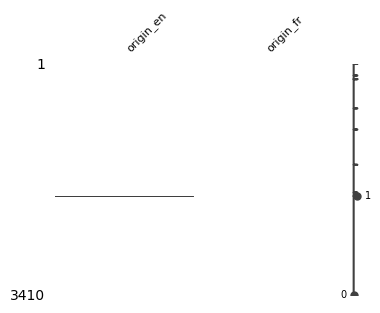

In [34]:
_ = msno.matrix(df=origin_lang_df, figsize=(4,3), fontsize=8)

In [35]:
# This does not seem to be useful, so I add the columns in the removal list:
removed_columns.extend(origin_lang_list)

## 2.5. Selection of the 'ingredients_text_[...]'

In [48]:
# Ingredients are listed in different languages, I'll check their completion:
# Display all the columns (30) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

ingred_txt_lang_df = init_data.filter(regex=('^ingredients_text_'))
ingred_txt_lang_df.head(5)

,ingredients_text_bg,ingredients_text_cs,ingredients_text_da,ingredients_text_de,ingredients_text_en,ingredients_text_es,ingredients_text_et,ingredients_text_fi,ingredients_text_fr,ingredients_text_hr,...,ingredients_text_pl,ingredients_text_pt,ingredients_text_ro,ingredients_text_sk,ingredients_text_sr,ingredients_text_sv,ingredients_text_ta,ingredients_text_th,ingredients_text_uk,ingredients_text_zh
0,NaN,NaN,NaN,NaN,"Water, freshly brewed black tea, suc...",NaN,NaN,NaN,"Water, black tea, sucrose, flavourin...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,"Wasser, 32% gekochte Linsen, 6,4% Bo...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Грис от твърда пшеница, вода.",NaN,NaN,"Hartweizengrieß, Wasser.","wheat semolina, water, egg",NaN,NaN,NaN,"Semoule de BLÉ dur, eau. Peut conten...","Krupica durum pšenice, voda. Može sa...",...,NaN,"sêmola de trigo, água, ovo",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,"Sugars (sugar, wheat syrup, maltodex...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,"for best before, see cool, dry place...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# I also save these columns in a list:
ingred_txt_lang_list = init_data.filter(
    regex=('^ingredients_text_')).columns.to_list()

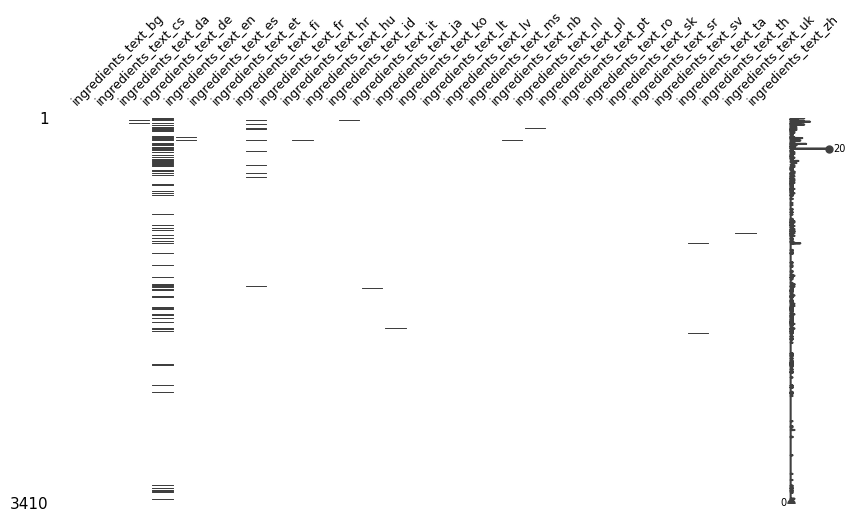

In [38]:
_ = msno.matrix(df=ingred_txt_lang_df, figsize=(10,5), fontsize=9)

In [39]:
# Since the ingredients are mostly available in English (also in French,
# but in a lesser extent), I only keep the '_en' variable:
ingred_txt_lang_list.remove('ingredients_text_en')

In [40]:
# I add the other columns in the removal list:
removed_columns.extend(ingred_txt_lang_list)

# 3. Data preparation (cleaning and completion)

In [41]:
# Let's start by removing the columns from the previous section
# init_data.columns.tolist() -> converts the columns into a list.
# Then using list comprehension to compute the difference of the two lists
# while maintaining the original order.
cleaning_df = init_data[
    [col for col in init_data.columns.tolist() if col not in removed_columns]]

In [42]:
# Let's have a look at the shape now:
print("The dataset now contains {} rows and {} columns".format(
    cleaning_df.shape[0], cleaning_df.shape[1]))

The dataset now contains 3410 rows and 270 columns


In [44]:
# Overview of what information it contains.
# Display all the columns (270) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

cleaning_df.head(5)

,code,producer_version_id,lc,product_name_en,quantity,serving_size,packaging,packaging_tags,brands,brands_tags,...,sources_fields:org-database-usda:publication_date,sources_fields:org-gs1:gln,sources_fields:org-gs1:gpcCategoryCode,sources_fields:org-gs1:gpcCategoryName,sources_fields:org-gs1:isAllergenRelevantDataProvided,sources_fields:org-gs1:lastChangeDateTime,sources_fields:org-gs1:partyName,sources_fields:org-gs1:productionVariantDescription,sources_fields:org-gs1:publicationDateTime,data_sources
0,8888196441119,NaN,fr,NaN,250 ml,250 ml,en:Tetra Brick Aseptic TetraPak,en:tetra-brick-aseptic-tetrapak,Pokka,pokka,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Open Food Facts"
1,4037300108293,NaN,de,NaN,425ml,400 g,"Metall, Dose, Konserve, Stahl","en:metal,en:can,en:canned,en:steel","Erasco,Continental Foods Germany,GB ...","erasco,continental-foods-germany,gb-...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Speisekammer..."
2,8076802085981,1,it,Fusilli Pasta,500 g,80 g,"Cartone, 21 PAP, Pacchetto, en:Card-box","en:cardboard,en:non-corrugated-cardb...","Barilla, Barilla und Birkel","barilla,barilla-und-birkel",...,NaN,3.012289e+12,10000242.0,Pâtes/Nouilles - Non Prêt à Consomme...,True,2022-12-29T11:06:43+01:00,BARILLA FRANCE SA,1,2022-12-29T11:06:43+01:00,"Producers, Producer - Barilla, Datab..."
3,73390000110,NaN,en,Mint Mentos,37 g,NaN,Mixed plastic-wrapper,en:mixed-plastic-wrapper,Mentos,mentos,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Horizon, App..."
4,734349,NaN,en,Honey roasted cashews,NaN,NaN,"Pot, Jar, Pp-lid","en:pot,en:jar,en:pp-lid",Marks & Spencer,marks-spencer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Horizon, App..."


The main idea here is:
- determine which are the most determining variables for the Nutri-Score,
- knowing the value of some of these variables for a given product, is it possible to predict its Nutri-Score?

According to its [definition](https://en.wikipedia.org/wiki/Nutri-Score), the Nutri-Score is calculated as __total N score - total P score = Nutritional score__:
- Product ingredients negatively (__N__) affecting the Nutri-Score:
  - Energy density (kcal/100g, kcal/100ml for beverages),
  - Simple sugars (g/100g, g/100ml for beverages),
  - Saturated fats (g/100g, % for cooking fats),
  - Salt (mg/100g),
- Product ingredients positively (__P__) affecting the Nutri-Score:
  - Fruit and vegetables (%),
  - Fibre (g/100g),
  - Protein (g/100g).

These are the columns I keep at minima.

In [ ]:
# IDEA: Use the Eco-Score and compare/use both
# https://en.wikipedia.org/wiki/Eco-score

In [45]:
# Each product is named in different languages, I'll check their completion.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

avail_scores = cleaning_df.filter(regex=('score'))
avail_scores.head(5)

,nutriscore_score_producer,nutriscore_grade_producer,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score,off:ecoscore_data.missing_key_data,off:ecoscore_data.agribalyse.code,off:ecoscore_data.adjustments.origins_of_ingredients.value,off:ecoscore_data.adjustments.packaging.value,off:ecoscore_data.adjustments.packaging.non_recyclable_and_non_biodegradable_materials,off:ecoscore_data.adjustments.production_system.value,off:ecoscore_data.adjustments.threatened_species.value
0,NaN,NaN,d,8.0,c,54.0,NaN,18015,NaN,-4.0,1.0,0.0,NaN
1,NaN,NaN,b,0.0,unknown,NaN,NaN,NaN,NaN,-2.0,0.0,0.0,NaN
2,NaN,NaN,a,-4.0,a,89.0,NaN,9810,NaN,-1.0,0.0,0.0,NaN
3,NaN,NaN,NaN,NaN,c,47.0,NaN,31003,NaN,-10.0,1.0,0.0,NaN
4,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,-12.0,0.0,0.0,NaN


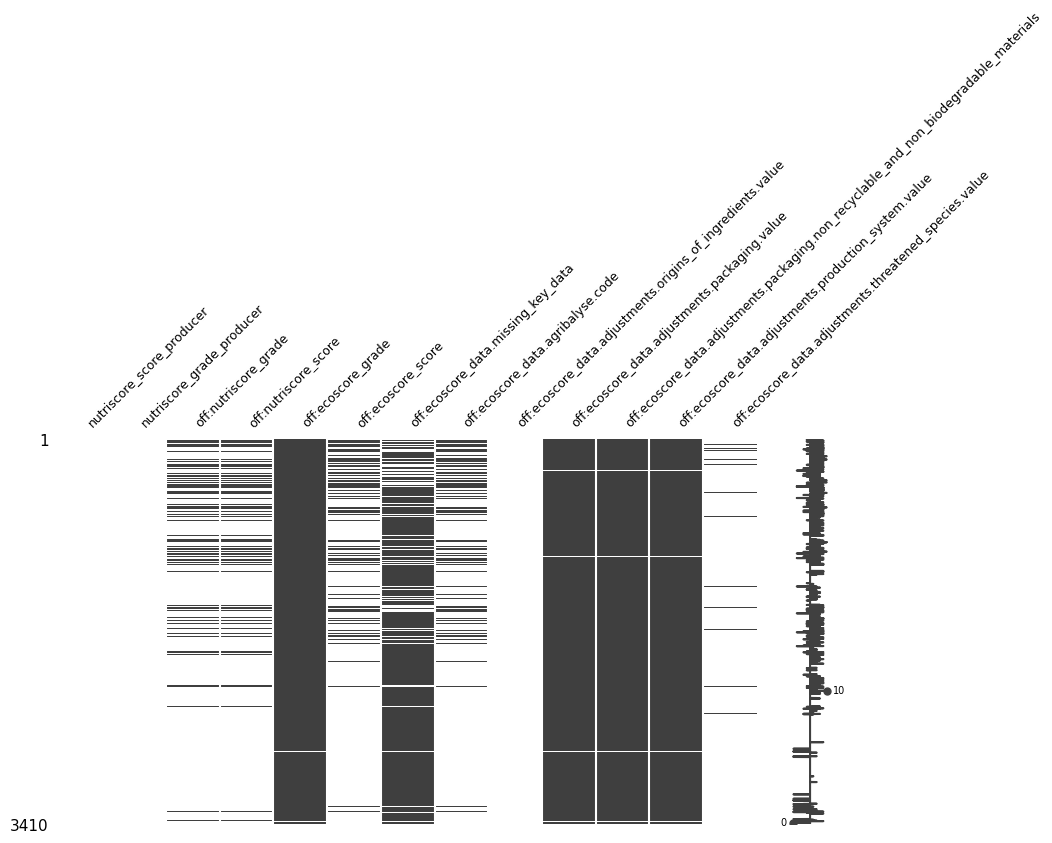

In [49]:
_ = msno.matrix(df=avail_scores, figsize=(10,5), fontsize=9)

## 3.1. Filtering the data according to the idea

In [50]:
# I initialize a list of columns to remove
drop_cols = []

### 3.1.1. Ending in '_tags'

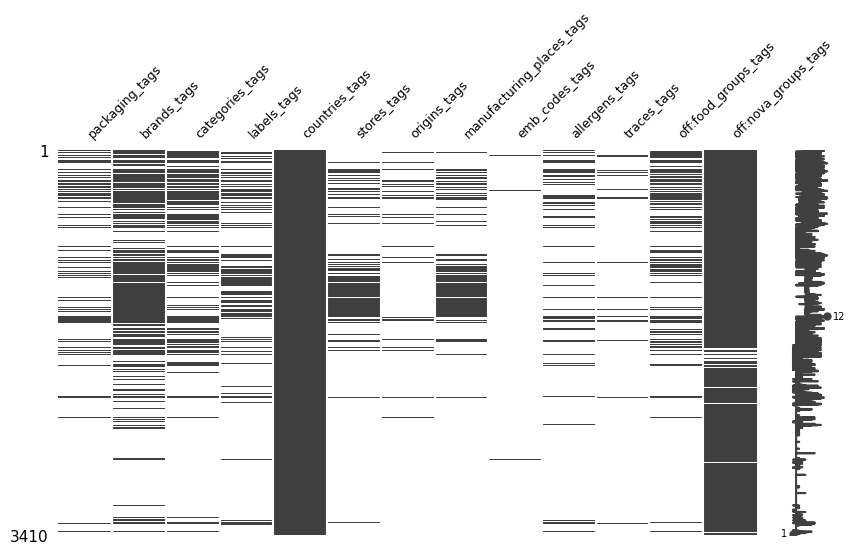

In [51]:
# I'll start by looking at some subsets of the data
subset_df = cleaning_df.filter(regex=('_tags$'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [53]:
# From this list, I remove the columns I want to keep
removed_list.remove('brands_tags')
removed_list.remove('countries_tags')
removed_list.remove('off:nova_groups_tags')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.2. Containing 'energy'

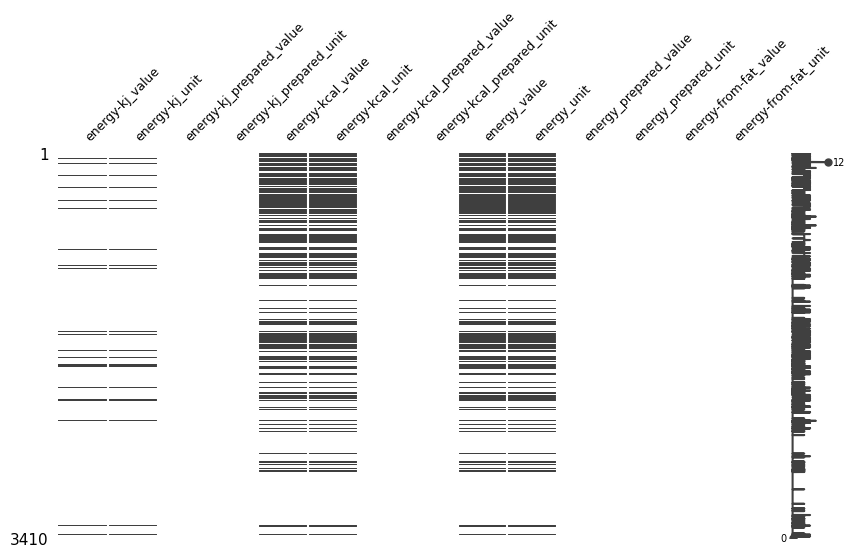

In [54]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('energy'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [56]:
# From this list, I remove the columns I want to keep
removed_list.remove('energy-kcal_value')
removed_list.remove('energy-kcal_unit')
removed_list.remove('energy_value')
removed_list.remove('energy_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.3. Containing 'fat_'

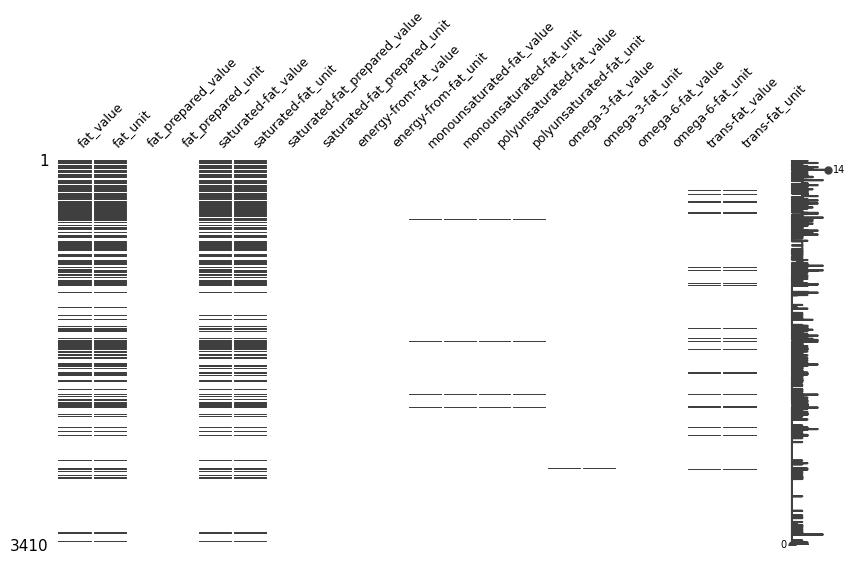

In [57]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('fat_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [59]:
# From this list, I remove the columns I want to keep
removed_list.remove('fat_value')
removed_list.remove('fat_unit')
removed_list.remove('saturated-fat_value')
removed_list.remove('saturated-fat_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.4. Containing 'carbohydrates_'

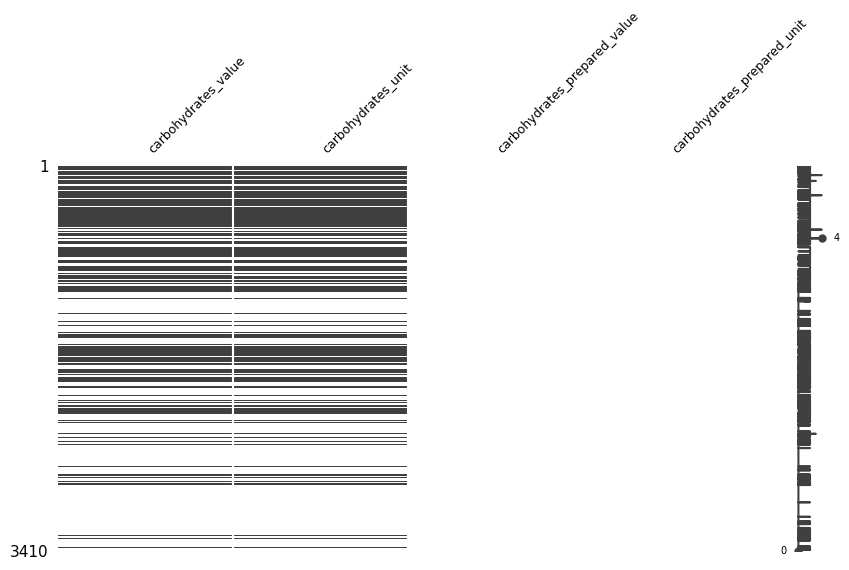

In [60]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('carbohydrates_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [62]:
# From this list, I remove the columns I want to keep
removed_list.remove('carbohydrates_value')
removed_list.remove('carbohydrates_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.5. Containing 'sugars_'

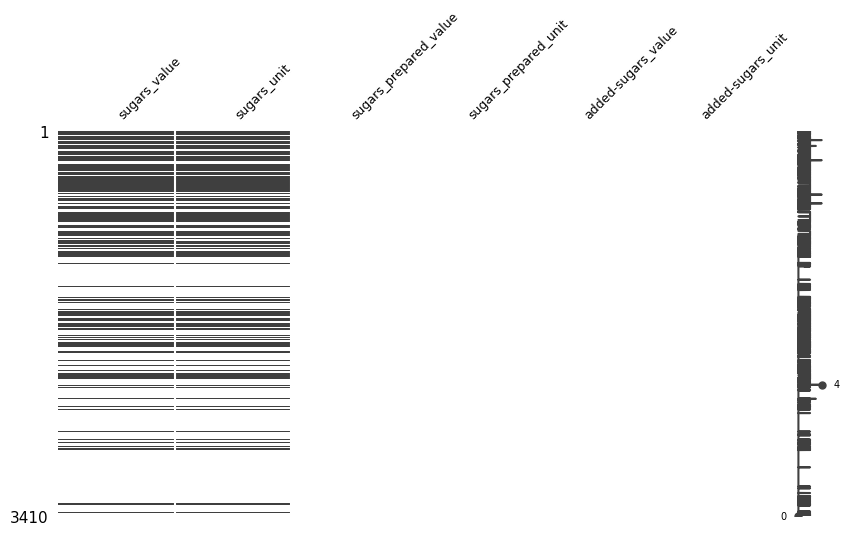

In [65]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('sugars_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [66]:
# From this list, I remove the columns I want to keep
removed_list.remove('sugars_value')
removed_list.remove('sugars_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.6. Containing 'fiber_'

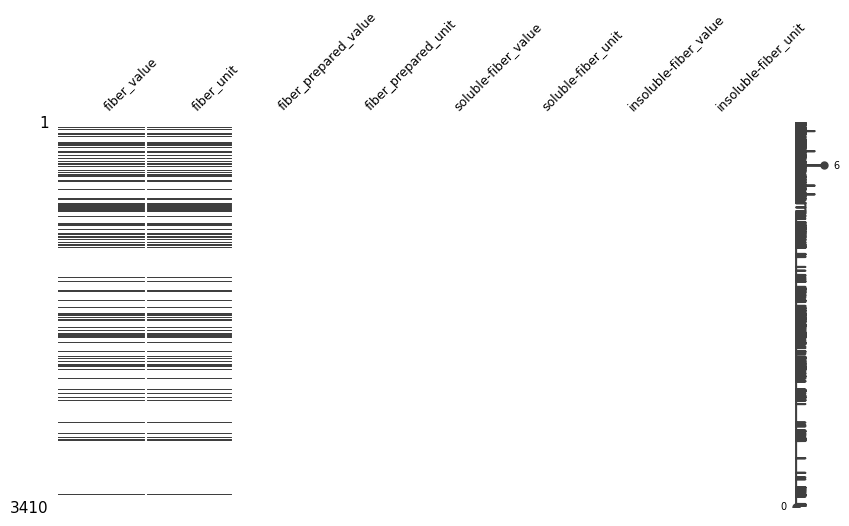

In [67]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('fiber_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [68]:
# From this list, I remove the columns I want to keep
removed_list.remove('fiber_value')
removed_list.remove('fiber_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.7. Containing 'proteins_'

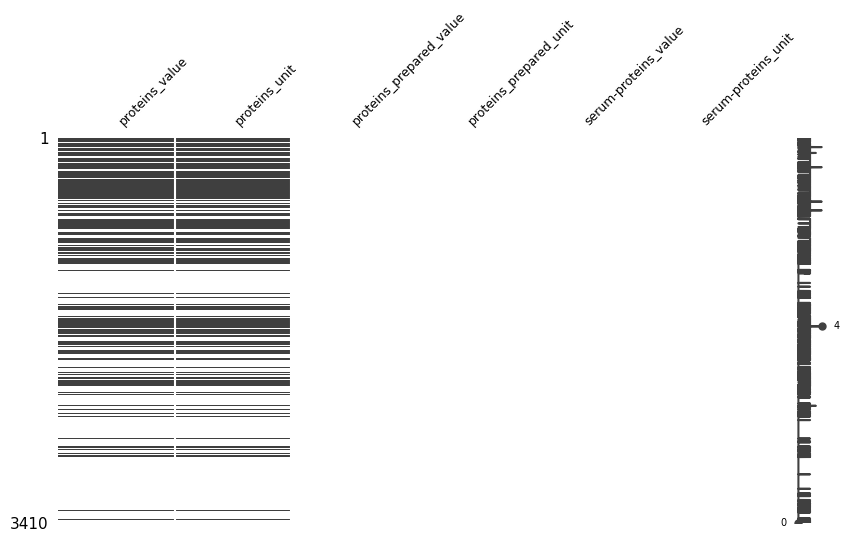

In [69]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('proteins_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [70]:
# From this list, I remove the columns I want to keep
removed_list.remove('proteins_value')
removed_list.remove('proteins_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.8. Containing 'salt_'

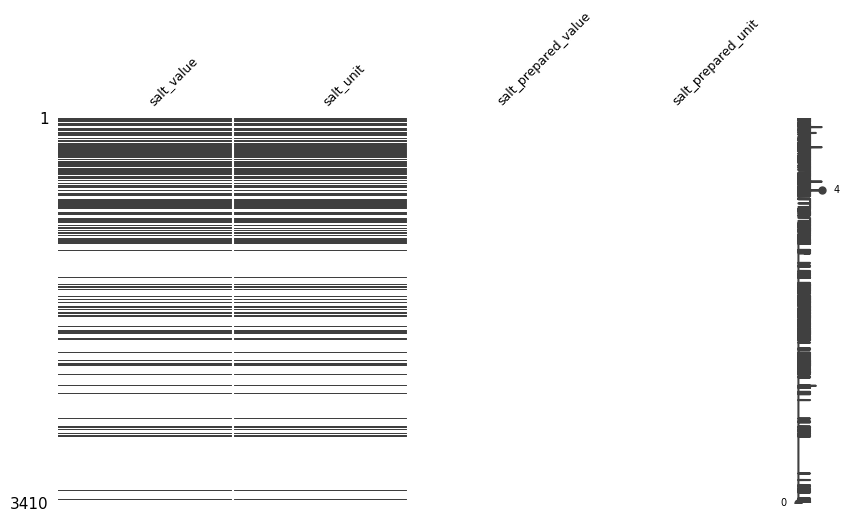

In [71]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('salt_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [72]:
# From this list, I remove the columns I want to keep
removed_list.remove('salt_value')
removed_list.remove('salt_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.9. Containing 'sodium_'

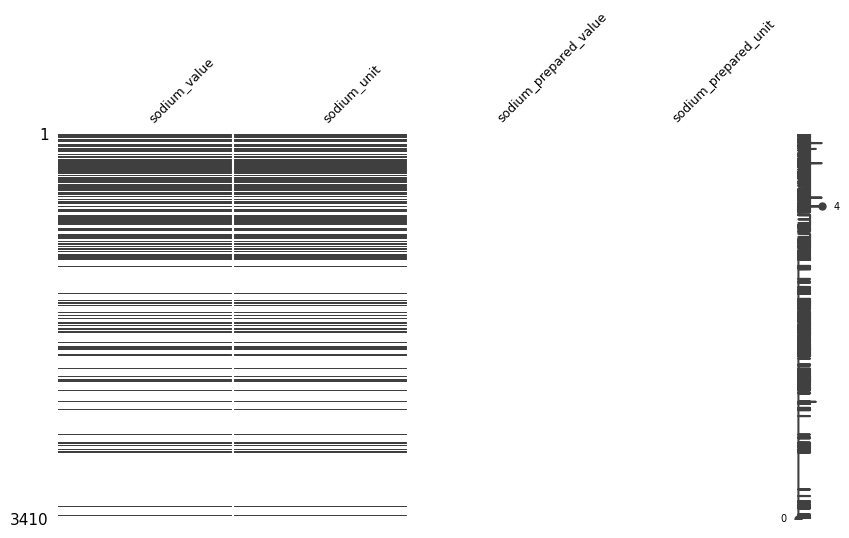

In [73]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('sodium_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [74]:
# From this list, I remove the columns I want to keep
removed_list.remove('sodium_value')
removed_list.remove('sodium_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.10. Containing '-acid_'

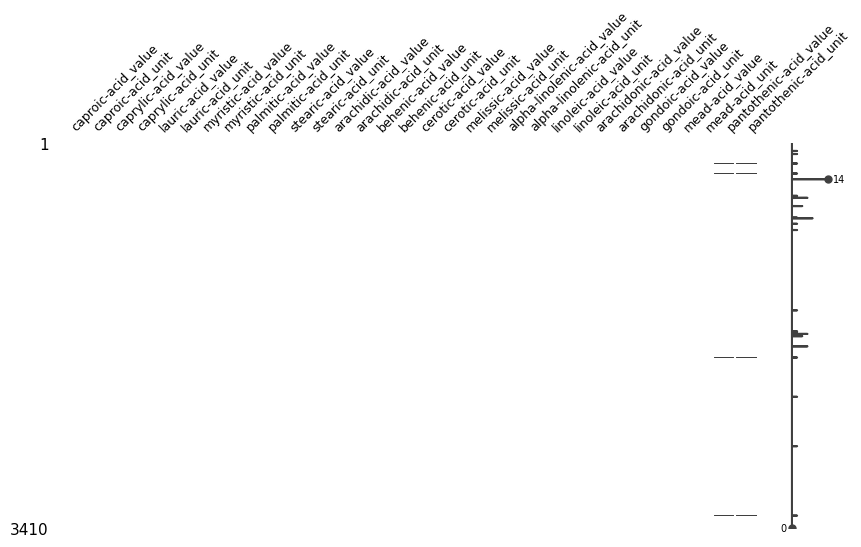

In [75]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('-acid_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [76]:
# This appears to be mostly empty, so I add the whole list in the removal list
drop_cols.extend(removed_list)

### 3.1.11. Containing 'vitamin-'

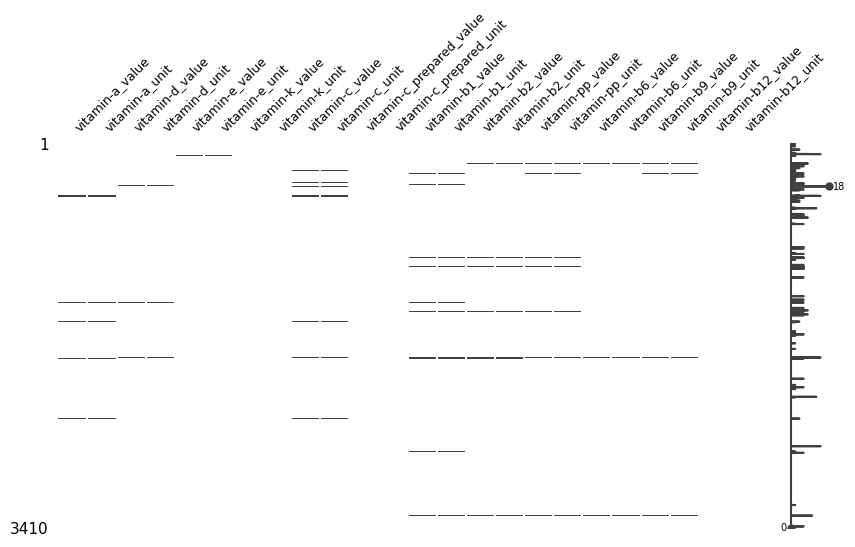

In [77]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('vitamin-'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [78]:
# This appears to be mostly empty, so I add the whole list in the removal list
drop_cols.extend(removed_list)

### 3.1.12. Containing 'packaging_'

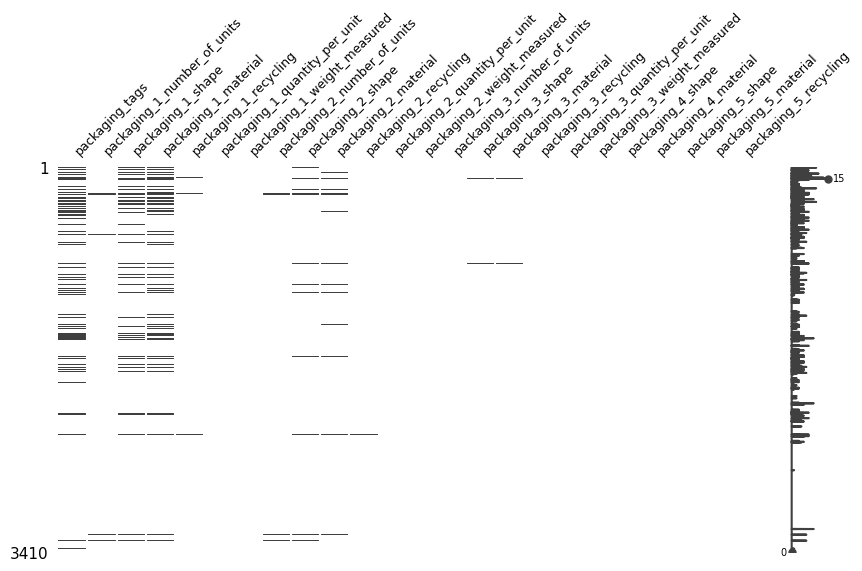

In [79]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('packaging_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [80]:
# From this list, I remove the column I want to keep
removed_list.remove('packaging_tags')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.13. Containing 'nutriscore_'

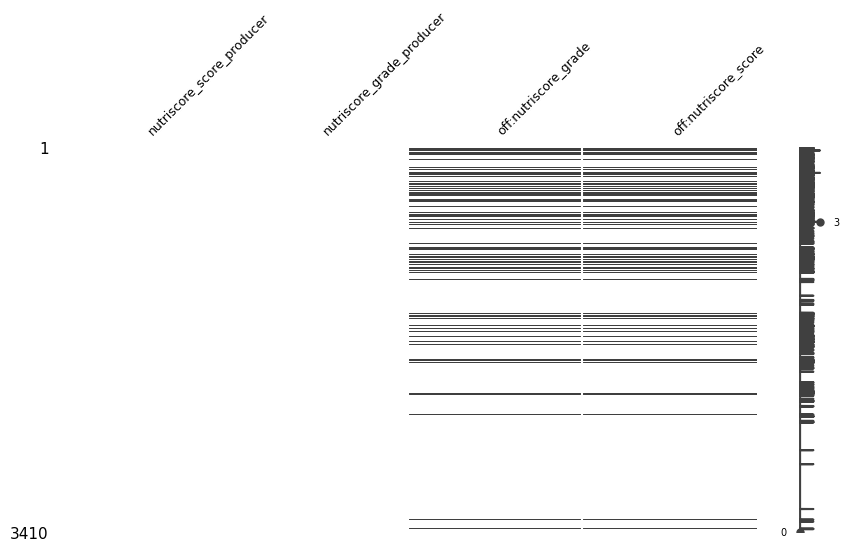

In [84]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('nutriscore_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [85]:
# From this list, I remove the columns I want to keep
removed_list.remove('off:nutriscore_grade')
removed_list.remove('off:nutriscore_score')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### (additional) 3.1.14. Containing 'ecoscore_'

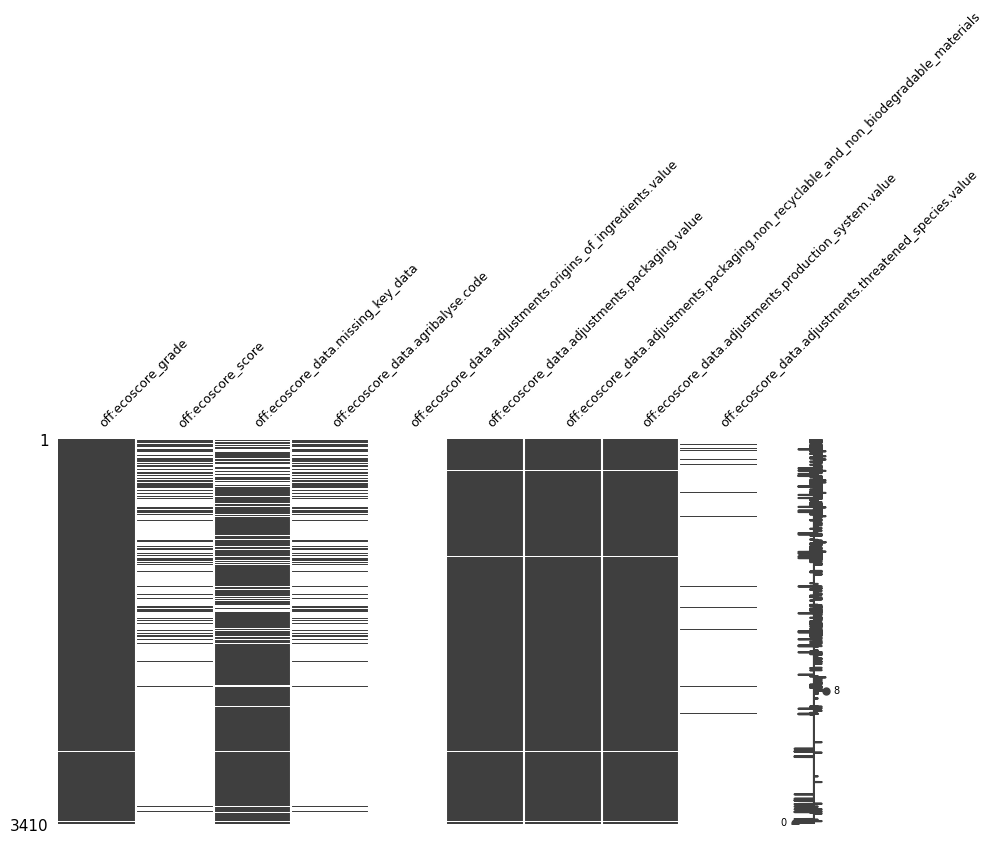

In [86]:
# I repeat the same process for another interesting keyword
subset_df = cleaning_df.filter(regex=('ecoscore_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [87]:
# From this list, I remove the column I want to keep
removed_list.remove('off:ecoscore_grade')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

## 3.2. TITLE

In [88]:
# Let's start by removing the columns from the previous section
# cleaning_df.columns.tolist() -> converts the columns into a list.
# Then using list comprehension to compute the difference of the two lists
# while maintaining the original order.
clean2_df = cleaning_df[
    [col for col in cleaning_df.columns.tolist() if col not in drop_cols]]

In [89]:
# Let's have a look at the shape now:
print("The dataset now contains {} rows and {} columns".format(
    clean2_df.shape[0], clean2_df.shape[1]))

The dataset now contains 3410 rows and 127 columns


In [91]:
# Overview of what information it contains.
# Display all the columns (127) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

clean2_df.head(5)

,code,producer_version_id,lc,product_name_en,quantity,serving_size,packaging,brands,brands_tags,brand_owner,...,sources_fields:org-database-usda:publication_date,sources_fields:org-gs1:gln,sources_fields:org-gs1:gpcCategoryCode,sources_fields:org-gs1:gpcCategoryName,sources_fields:org-gs1:isAllergenRelevantDataProvided,sources_fields:org-gs1:lastChangeDateTime,sources_fields:org-gs1:partyName,sources_fields:org-gs1:productionVariantDescription,sources_fields:org-gs1:publicationDateTime,data_sources
0,8888196441119,NaN,fr,NaN,250 ml,250 ml,en:Tetra Brick Aseptic TetraPak,Pokka,pokka,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Open Food Facts"
1,4037300108293,NaN,de,NaN,425ml,400 g,"Metall, Dose, Konserve, Stahl","Erasco,Continental Foods Germany,GB ...","erasco,continental-foods-germany,gb-...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Speisekammer..."
2,8076802085981,1,it,Fusilli Pasta,500 g,80 g,"Cartone, 21 PAP, Pacchetto, en:Card-box","Barilla, Barilla und Birkel","barilla,barilla-und-birkel",NaN,...,NaN,3.012289e+12,10000242.0,Pâtes/Nouilles - Non Prêt à Consomme...,True,2022-12-29T11:06:43+01:00,BARILLA FRANCE SA,1,2022-12-29T11:06:43+01:00,"Producers, Producer - Barilla, Datab..."
3,73390000110,NaN,en,Mint Mentos,37 g,NaN,Mixed plastic-wrapper,Mentos,mentos,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Horizon, App..."
4,734349,NaN,en,Honey roasted cashews,NaN,NaN,"Pot, Jar, Pp-lid",Marks & Spencer,marks-spencer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Horizon, App..."
